In [1]:
#Read in libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')


In [2]:
#Read in data
%cd '/home/kishen/Documents/Data Science/Projects/Customer Segmentation/data'

raw_data= pd.read_excel('Online Retail.xlsx', engine='openpyxl',
                        date_parser= 'InvoiceDate',dtype= {'CustomerID': 'object'})

/home/kishen/Documents/Data Science/Projects/Customer Segmentation/data


**Preview and Inspect Data**

In [3]:
#Preview data
display(raw_data.shape)
raw_data.head()

(541909, 8)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


**Preprocessing**

In [4]:
#Remove rows without a CustomerId
clean_df= raw_data.loc[~(raw_data.CustomerID.isna())]
                         
#Keep rows in UK only (Vast majority of customers are located here)
clean_df= clean_df.loc[clean_df['Country'] == 'United Kingdom']

## Customer Segmentation - RFM Analysis

In [5]:
#Prepare data for rfm analys
clean_df.loc[:,'Total']= clean_df['Quantity'] * clean_df['UnitPrice']

In [6]:
clean_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


**Recency**

In [7]:
#Determine earliest and latest dates
display(clean_df.InvoiceDate.max())
display(clean_df.InvoiceDate.min())

Timestamp('2011-12-09 12:49:00')

Timestamp('2010-12-01 08:26:00')

In [8]:
clean_df.sort_values(by= 'CustomerID').head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,-77183.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.60
64851,541677,82494L,WOODEN FRAME ANTIQUE WHITE,12,2011-01-20 14:01:00,2.95,12747,United Kingdom,35.40
64850,541677,82484,WOOD BLACK BOARD ANT WHITE FINISH,36,2011-01-20 14:01:00,5.55,12747,United Kingdom,199.80
64849,541677,21136,PAINTED METAL PEARS ASSORTED,16,2011-01-20 14:01:00,1.69,12747,United Kingdom,27.04
9760,537215,21136,PAINTED METAL PEARS ASSORTED,8,2010-12-05 15:38:00,1.69,12747,United Kingdom,13.52
27397,538537,82482,WOODEN PICTURE FRAME WHITE FINISH,12,2010-12-13 10:41:00,2.55,12747,United Kingdom,30.60
27396,538537,82484,WOOD BLACK BOARD ANT WHITE FINISH,12,2010-12-13 10:41:00,5.55,12747,United Kingdom,66.60
9759,537215,82484,WOOD BLACK BOARD ANT WHITE FINISH,36,2010-12-05 15:38:00,5.55,12747,United Kingdom,199.80
9758,537215,85064,CREAM SWEETHEART LETTER RACK,6,2010-12-05 15:38:00,5.45,12747,United Kingdom,32.70


In [9]:
#We'll set now as 2011-12-10 and calculate recency using this date
import datetime as dt
NOW= dt.datetime(2011,12,10)

#Create RFM table
rfmTable= clean_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days,
                                    'InvoiceNo': lambda x: len(x),
                                    'Total': lambda x: x.sum()})

rfmTable.columns= ['recency', 'frequency', 'total']
#rfmTable['recency']= pd.to_timedelta(rfmTable['recency'], unit= 'D')
rfmTable

,recency,frequency,total
CustomerID,,,
12346,325,2,0.00
12747,2,103,4196.01
12748,0,4642,29072.10
12749,3,231,3868.20
12820,3,59,942.34
...,...,...,...
18280,277,10,180.60
18281,180,7,80.82
18282,7,13,176.60


In [10]:
#Assign quantiles
rfmTable.loc[:, 'r_quantiles']= pd.qcut(rfmTable['recency'], q= 4, labels= False) + 1
rfmTable.loc[:, 'f_quantiles']= pd.qcut(rfmTable['frequency'], q= 4, labels= False) + 1
rfmTable.loc[:, 't_quantiles']= pd.qcut(rfmTable['total'], q= 4, labels= False) + 1

#Concat into rfm score
rfmTable.loc[:, 'rfm_score']= (rfmTable['r_quantiles'].map(str) + 
                              rfmTable['f_quantiles'].map(str) + 
                              rfmTable['t_quantiles'].map(str))

#Check
display(rfmTable.head())

,recency,frequency,total,r_quantiles,f_quantiles,t_quantiles,rfm_score
CustomerID,,,,,,,
12346,325,2,0.00,4,1,1,411
12747,2,103,4196.01,1,4,4,144
12748,0,4642,29072.10,1,4,4,144
12749,3,231,3868.20,1,4,4,144
12820,3,59,942.34,1,3,3,133


In [11]:
#View the top consumers
rfmTable.sort_values(by='rfm_score', inplace= True)
display(rfmTable.head(10))

,recency,frequency,total,r_quantiles,f_quantiles,t_quantiles,rfm_score
CustomerID,,,,,,,
12962,7,16,266.39,1,1,1,111
13436,1,12,196.89,1,1,1,111
17468,10,5,137.00,1,1,1,111
16988,5,7,126.12,1,1,1,111
18058,9,3,170.16,1,1,1,111
13017,7,1,204.00,1,1,1,111
16620,3,9,178.96,1,1,1,111
14520,1,4,270.60,1,1,1,111
18030,4,10,220.70,1,1,1,111


In [12]:
#View the almost lost consumers
rfmTable.loc[rfmTable['rfm_score']== '311'].head(10)

,recency,frequency,total,r_quantiles,f_quantiles,t_quantiles,rfm_score
CustomerID,,,,,,,
16462,64,4,102.00,3,1,1,311
13690,59,9,172.25,3,1,1,311
16428,81,1,-2.95,3,1,1,311
16468,74,2,74.90,3,1,1,311
16451,87,14,266.97,3,1,1,311
16542,53,5,119.62,3,1,1,311
17256,107,16,240.00,3,1,1,311
14761,58,11,255.90,3,1,1,311
14208,94,10,151.74,3,1,1,311


## Customer Segmentation - K-Means Analysis

**Prepare data**

In [13]:
#Subset necessary cols from rfmTable
kmeansTable= rfmTable.iloc[:,:3 ]

kmeansTable

,recency,frequency,total
CustomerID,,,
12962,7,16,266.39
13436,1,12,196.89
17468,10,5,137.00
16988,5,7,126.12
18058,9,3,170.16
...,...,...,...
17504,206,140,2745.28
17787,152,134,1865.19
16919,156,327,2596.45


Recency

In [14]:
#Read in libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [15]:
#Find optimum number of clusters for recency
cluster_labels = list(range(2,8))

X= np.array(kmeansTable['recency'].values).reshape(len(kmeansTable['recency'].values), 1)

sil_scores= []
for cluster in cluster_labels:
    kmeans= KMeans(n_clusters= cluster, random_state= 10)
    kmean_labels= kmeans.fit_predict(X)
    
    sil_scores.append(silhouette_score(X, labels=kmean_labels))

Text(0.5, 0, 'Number of Clusters')

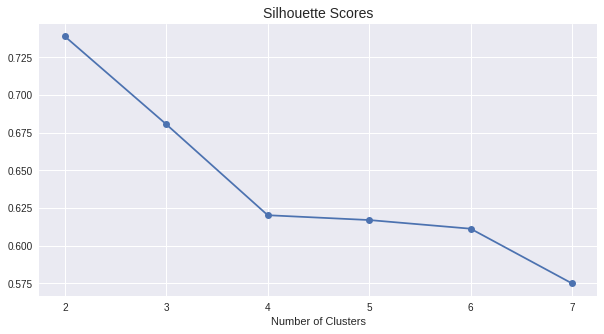

In [16]:
#Visualize silhouette scores
f, ax= plt.subplots(figsize=(10,5))
ax.plot(cluster_labels, sil_scores, marker= 'o')

ax.set_title('Silhouette Scores', fontsize= 14)
ax.set_xlabel('Number of Clusters')

In [17]:
kmeans= KMeans(n_clusters= 3, random_state= 10)
kmeansTable['recency_groups']= kmeans.fit_predict(X)

**Frequency**

In [19]:
#Find optimum number of clusters for frequency
cluster_labels = list(range(2,8))

X= np.array(kmeansTable['frequency'].values).reshape(len(kmeansTable['frequency'].values), 1)

sil_scores= []
for cluster in cluster_labels:
    kmeans= KMeans(n_clusters= cluster, random_state= 10)
    kmean_labels= kmeans.fit_predict(X)
    
    sil_scores.append(silhouette_score(X, labels=kmean_labels))

Text(0.5, 0, 'Number of Clusters')

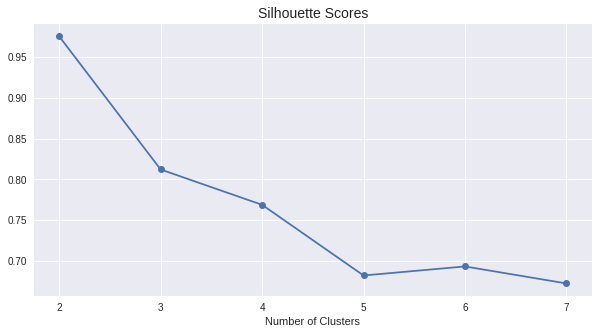

In [20]:
#Visualize silhouette scores
f, ax= plt.subplots(figsize=(10,5))
ax.plot(cluster_labels, sil_scores, marker= 'o')

ax.set_title('Silhouette Scores', fontsize= 14)
ax.set_xlabel('Number of Clusters')

In [39]:
kmeans= KMeans(n_clusters= 4, random_state= 10)
kmeansTable['frequency_groups']= kmeans.fit_predict(X)

#Check groups
kmeansTable.groupby('frequency_groups')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_groups,,,,,,,,
0,3687.0,67.382967,88.061395,1.0,16.0,37.0,86.00,981.0
1,2.0,392.000000,57.982756,351.0,371.5,392.0,412.50,433.0
2,27.0,1165.703704,1878.899326,45.0,194.0,410.0,1068.50,7983.0
3,234.0,346.918803,314.051084,4.0,158.0,284.5,421.75,2782.0


Higher frequency_group values indicate better customers who have shopped more frequently with business.

Total

In [23]:
#Find optimum number of clusters for frequency
cluster_labels = list(range(2,8))

X= np.array(kmeansTable['total'].values).reshape(len(kmeansTable['total'].values), 1)

sil_scores= []
for cluster in cluster_labels:
    kmeans= KMeans(n_clusters= cluster, random_state= 10)
    kmean_labels= kmeans.fit_predict(X)
    
    sil_scores.append(silhouette_score(X, labels=kmean_labels))

Text(0.5, 0, 'Number of Clusters')

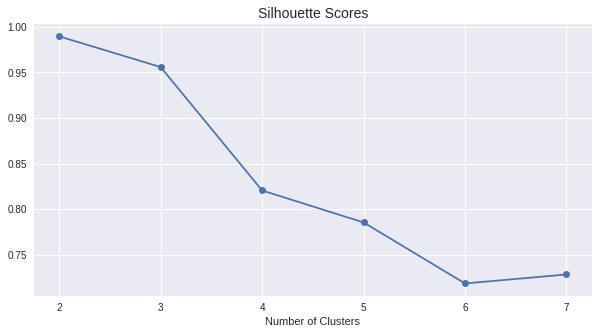

In [24]:
#Visualize silhouette scores
f, ax= plt.subplots(figsize=(10,5))
ax.plot(cluster_labels, sil_scores, marker= 'o')

ax.set_title('Silhouette Scores', fontsize= 14)
ax.set_xlabel('Number of Clusters')

In [46]:
kmeans= KMeans(n_clusters= 3, random_state= 10)
kmeansTable['total_groups']= kmeans.fit_predict(X)

In [47]:
kmeansTable.groupby('total_groups')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
total_groups,,,,,,,,
0,3921.0,1316.258790,2054.745461,-4287.63,280.52,621.66,1487.80,21535.90
1,2.0,221960.330000,48759.481478,187482.17,204721.25,221960.33,239199.41,256438.49
2,27.0,43070.445185,15939.249588,25748.35,28865.49,36351.42,53489.79,88125.38


Aggregating clusters

In [29]:
kmeansTable

,recency,frequency,total,recency_groups,frequency_groups,total_groups
CustomerID,,,,,,
12962,7,16,266.39,1,0,0
13436,1,12,196.89,1,0,0
17468,10,5,137.00,1,0,0
16988,5,7,126.12,1,0,0
18058,9,3,170.16,1,0,0
...,...,...,...,...,...,...
17504,206,140,2745.28,2,0,0
17787,152,134,1865.19,2,0,0
16919,156,327,2596.45,2,2,0
